## Data Cleaning for NLP


* Summary
* Loading Data 
* Initial Inspection
    * Discarding Features
* Data cleaning for NLP    
* EDA/Feature Engineering
    * Sentiment Analysis

### Summary

In this section we perform NLP related data cleaning and EDA on the human and bot tweet-level dataset. Results of analyzing features indicated that the most useful fields for our classification efforts are: **truncated, retweet count, favorite count, num hashtags, num urls, and num mentions**. Engineered fields that could support classification are sentiment based fields (**ratio_positive, ratio_negative, ratio_neutral**) and **place_binary**.

### Loading Data

This dataset is comprised of about 50,000 human tweets and 60,000 bot tweets. There are 26 features and one response. The tweet content is in a column called 'text' within the tweets.csv files.  The 'user_type' is our response variable and contains a 1 if the account is a bot.

To conduct our analysis, first we import all the modules and functions we will use in this stage of analysis.

In [1]:
import pandas as pd
import numpy as np
import langdetect
#either pip install langdetect or conda install -c conda-forge langdetect
from langdetect import detect
from pandas.plotting import scatter_matrix
import re
#conda install -c conda-forge textblob 
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
import html
from html.parser import HTMLParser
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
import textblob
from textblob import TextBlob
import string
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import matplotlib.pyplot as plt

Next we load the data and concatenate the human and bot tweet files into a single dataframe called tweets. 

In [2]:
#read in all the tweets from geniuine accounts
human_tweets = pd.read_csv('~/Documents/GitHub/cs109a/data/human_tweets_100.csv')
bot_tweets = pd.read_csv('~/Documents/GitHub/cs109a/data/bot_tweets_100.csv')
sbot_tweets = pd.read_csv('~/Documents/GitHub/cs109a/data/social_tweets_100.csv')
human_tweets = human_tweets.drop(["Unnamed: 0", "Unnamed: 0.1"], axis=1)
bot_tweets = bot_tweets.drop(["Unnamed: 0", "Unnamed: 0.1"], axis=1)
sbot_tweets = sbot_tweets.drop(["Unnamed: 0", "Unnamed: 0.1"], axis=1)
#We will combine these two data sets then get a sample to analyze
tweets_some = pd.concat([human_tweets, bot_tweets], sort=False)
tweets = pd.concat([tweets_some, sbot_tweets], sort=False)
#tweets_train, tweets_test= train_test_split(tweets, test_size=0.3, stratify=tweets['user_type'], random_state=5)

### Initial Inspection
Using the .info method, we can do a quick analysis of the columns and see some predictors we can already eliminate.

In [3]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120394 entries, 0 to 10041
Data columns (total 27 columns):
id                         120394 non-null int64
text                       120260 non-null object
source                     120394 non-null object
user_id                    120394 non-null float64
truncated                  354 non-null float64
in_reply_to_status_id      120394 non-null int64
in_reply_to_user_id        120394 non-null int64
in_reply_to_screen_name    19419 non-null object
retweeted_status_id        120394 non-null int64
geo                        0 non-null float64
place                      1920 non-null object
contributors               0 non-null float64
retweet_count              120394 non-null int64
reply_count                120394 non-null int64
favorite_count             120394 non-null int64
favorited                  0 non-null float64
retweeted                  0 non-null float64
possibly_sensitive         0 non-null float64
num_hashtags         

In [4]:
tweets.describe()

,id,user_id,truncated,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,geo,contributors,retweet_count,reply_count,favorite_count,favorited,retweeted,possibly_sensitive,num_hashtags,num_urls,num_mentions,user_type,counts
count,1.203940e+05,1.203940e+05,354.0,1.203940e+05,1.203940e+05,1.203940e+05,0.0,0.0,1.203940e+05,120394.0,120394.000000,0.0,0.0,0.0,120394.000000,120394.000000,120394.000000,120394.000000,60944.000000
mean,2.192202e+17,6.175252e+08,1.0,5.348284e+16,8.755713e+07,4.592845e+16,NaN,NaN,3.223074e+02,0.0,0.116235,NaN,NaN,NaN,0.202867,0.491362,0.460214,0.410386,1900.994224
std,2.432904e+17,9.033170e+08,0.0,1.519032e+17,3.679532e+08,1.449689e+17,NaN,NaN,1.771989e+04,0.0,0.732170,NaN,NaN,NaN,0.635952,0.517175,0.874003,0.491906,1229.092513
min,6.460111e+06,8.872810e+05,1.0,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,0.000000e+00,0.0,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,1.000000
25%,8.076543e+09,3.896226e+07,1.0,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,0.000000e+00,0.0,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,669.000000
50%,2.785777e+10,7.895294e+07,1.0,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,0.000000e+00,0.0,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,2221.000000
75%,4.782912e+17,6.044007e+08,1.0,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,0.000000e+00,0.0,0.000000,NaN,NaN,NaN,0.000000,1.000000,1.000000,1.000000,3200.000000
max,5.941273e+17,2.386078e+09,1.0,5.940862e+17,3.198892e+09,5.941085e+17,NaN,NaN,3.350110e+06,0.0,54.000000,NaN,NaN,NaN,28.000000,4.000000,17.000000,1.000000,3200.000000


### Features to discard for this analysis

Analyzing the .info() output shows us that five of the features are empty or have 0 for every value: 'geo', 'contributors', 'favorited', 'possibly_sensitive', 'retweeted', 'reply_count'.

Since we are not performing any network analysis, we will also drop the 'in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', which are fields that can be used to reconstruct communications connectivity of an individual tweet. 

Other fields that are researcher or twitter generated metadata that we will remove are id:(tweet id), source:(unknown), created_at, crawled_at, updated. Since we are not performing time series analysis, we will also remove timestamp. 

In [5]:
remove = ['geo', 'contributors', 'favorited', 'counts', 'possibly_sensitive', 'retweeted', 'reply_count','in_reply_to_screen_name', 'in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'id', 'source', 'created_at', 'crawled_at', 'updated', 'timestamp']
tweets = tweets.drop(columns=remove, axis=1)

### Data Cleaning for NLP

Next, we can start the cleaning process on the content of the tweets themselves. This is a necessary processing step to prepare the data for follow-on NLP techniques. We've written some functions, below, that will strip punctuation, url encoding, urls, stopwords, and lemmatize our data. 

In [6]:
#Functions
class MLStripper(HTMLParser):
    #https://docs.python.org/3/library/html.parser.html
    #https://stackoverflow.com/questions/11061058/using-htmlparser-in-python-3-2
    def __init__(self):
        super().__init__()
        self.reset()
        self.fed = []
       
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

def remove_swords(text):
    #https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
    stop_words = set(stopwords.words('english'))   
    word_tokens = word_tokenize(text)  
    filtered_sentence = [w for w in word_tokens if not w in stop_words]   
    return filtered_sentence

def get_tweet_sentiment(tweet): 
        ''' 
        https://medium.freecodecamp.org/basic-data-analysis-on-twitter-with-python-251c2a85062e 
        Utility function to classify sentiment of passed tweet 
        using textblob's sentiment method 
        '''
        # create TextBlob object of passed tweet text 
        analysis = TextBlob(tweet) 
        # set sentiment 
        if analysis.sentiment.polarity > 0: 
            return 'positive'
        elif analysis.sentiment.polarity == 0: 
            return 'neutral'
        else: 
            return 'negative'

def lemmatize(text):
    #https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21
    text_out = []
    def get_lemma(word):
        lemma = wn.morphy(word)
        if lemma is None:
            return word
        else:
            return lemma
    
    for word in text:
        lword = get_lemma(word)
        text_out.append(lword)
    return text_out

def nlp_clean(text):
    #get rid of #retweets RT @[\S]+  mentions @[\S]+ urls http:\S+|https\S+|www.\S+ punctuation
    text_out = []
    result = ''
    try:
        result = re.sub(r"RT @[\S]+: |@[\S]+|http:\S+|https\S+|www.\S+|[^\w\s]", "", text) 
        
         #to lower case
        result = result.lower()
        
        #get rid of url encoding
        #https://stackoverflow.com/questions/11061058/using-htmlparser-in-python-3-2
        result = strip_tags(result)

        #get rid of special ascii characters
        result = ''.join([c for c in result if ord(c) < 128])

       
        #get rid of stopwords
        result = remove_swords(result)

        #get word roots
        result = lemmatize(result)
        
    except:
        text_out = ['Failed']
    
    return result

def clean_tweets(df, text_col):
    #creates two new features
    #word_bag is our bag of words that has been cleaned
    #sentiment is the sentiment for the individual tweet
    df['word_bag'] = df[text_col].apply(lambda x: nlp_clean(x))
    
    return(df) 


Now we apply our NLP pre-processing

In [7]:
tweets = clean_tweets(tweets, 'text')

### EDA/Feature Engineering


#### Sentiment Analysis
Now we conduct sentiment analysis using the built-in sentiment method from the textblob module, an nltk wrapper. This method predicts sentiment based on a model trained on a labeled movie review corpus. First we load our functions.

In [8]:
#get sentiment
def sentiment(text):
    sentiment = get_tweet_sentiment(text)
    return sentiment 

#Functions to compute summary sentiment percentages  
#per user, per dataframe
def sum_sent(row):
    return row['neg_count'] + row['pos_count'] + row['ntl_count']

def ratio_pos(row):
    return row['pos_count']/row['sentiment_sum']

def ratio_neg(row):
    return row['neg_count']/row['sentiment_sum']

def ratio_neu(row):
    return row['ntl_count']/row['sentiment_sum']

def compute_sentiment_percentages(df, text_col, sentiment_col, user_id_col):
    #measure sentiment, then create dummy variables    
    df['sentiment'] = df[text_col].astype(str).apply(lambda x: sentiment(x))
    df = pd.get_dummies(df, columns=[sentiment_col])
    #get counts for each sentiment
    df['neg_count']=df.groupby([user_id_col])['sentiment_negative'].transform('sum')
    df['pos_count']=df.groupby([user_id_col])['sentiment_positive'].transform('sum')
    df['ntl_count']=df.groupby([user_id_col])['sentiment_neutral'].transform('sum')
    #compute sum
    df['sentiment_sum'] = df.apply(sum_sent, axis=1)
    df['ratio_pos'] = df.apply(ratio_pos, axis=1)
    df['ratio_neg'] = df.apply(ratio_neg, axis=1)
    df['ratio_neu'] = df.apply(ratio_neu, axis=1)
    return df

Then apply the sentiment analysis and compute overall percentages per user.

In [9]:
tweets = compute_sentiment_percentages(tweets, 'text', 'sentiment', 'user_id')

In [10]:
tweets.head(5)

,text,user_id,truncated,place,retweet_count,favorite_count,num_hashtags,num_urls,num_mentions,user_type,...,sentiment_negative,sentiment_neutral,sentiment_positive,neg_count,pos_count,ntl_count,sentiment_sum,ratio_pos,ratio_neg,ratio_neu
0,How Randolph Hodgson and Neals Yard Dairy gave...,887281.0,NaN,NaN,0,0,0,1,0,1,...,0,1,0,87.0,216.0,323.0,626.0,0.345048,0.138978,0.515974
1,“Twitter’s multi-billion dollar mistake happen...,887281.0,NaN,NaN,0,0,0,1,1,1,...,0,1,0,87.0,216.0,323.0,626.0,0.345048,0.138978,0.515974
2,The evolution of advertising in the legal sect...,887281.0,NaN,NaN,0,0,0,1,0,1,...,0,0,1,87.0,216.0,323.0,626.0,0.345048,0.138978,0.515974
3,RT @rorysutherland: Plan Bee - http://t.co/030...,887281.0,NaN,NaN,14,0,0,1,4,1,...,0,1,0,87.0,216.0,323.0,626.0,0.345048,0.138978,0.515974
4,RT @davewiner: Some say the Other Internet is ...,887281.0,NaN,NaN,3,0,0,1,1,1,...,1,0,0,87.0,216.0,323.0,626.0,0.345048,0.138978,0.515974


Since the sentiment percentages are computed from the counts, let's drop the sentiment counts before we analyze correlation.

In [11]:
tweets = tweets.drop(['neg_count','pos_count','ntl_count','sentiment_sum'], axis=1)

Also, let's convert the 'place' feature into a boolean.

In [12]:
tweets['place_bin'] = tweets.place.apply(lambda x: 1 if isinstance(x, str) else 0)

Now we can analyze the features. First, let's generate a scatter matrix from the non-textual or id based fields. 

In [16]:
tweets_corr = tweets.drop(['text','user_id','place','word_bag'], axis=1)
tweets_scatter = tweets_corr.drop(['ratio_pos','ratio_neg','ratio_neu'], axis=1)
#scatter_matrix(tweets_scatter)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 13 Text xticklabel objects>)

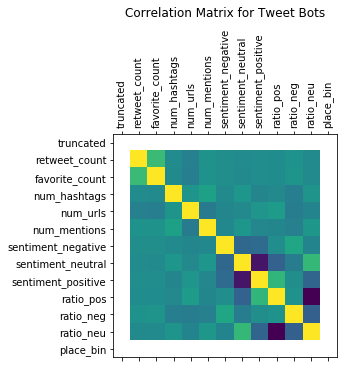

In [19]:
tweets_bots = tweets_corr[tweets_corr['user_type']==0]
tweets_bots = tweets_bots.drop(['user_type'], axis=1)
plt.matshow(tweets_bots.corr())
plt.title('Correlation Matrix for Tweet Bots', y=1.5)
plt.xticks(range(len(tweets_bots.columns)), tweets_bots.columns);
plt.yticks(range(len(tweets_bots.columns)), tweets_bots.columns);
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 13 Text xticklabel objects>)

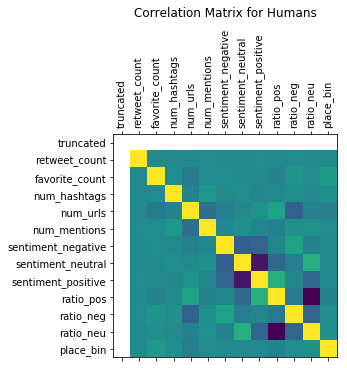

In [20]:
tweets_hums = tweets_corr[tweets_corr['user_type']==1]
tweets_hums = tweets_corr.drop(['user_type'], axis=1)
plt.matshow(tweets_hums.corr())
plt.title('Correlation Matrix for Humans', y=1.5)
plt.xticks(range(len(tweets_bots.columns)), tweets_bots.columns);
plt.yticks(range(len(tweets_bots.columns)), tweets_bots.columns);
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 13 Text xticklabel objects>)

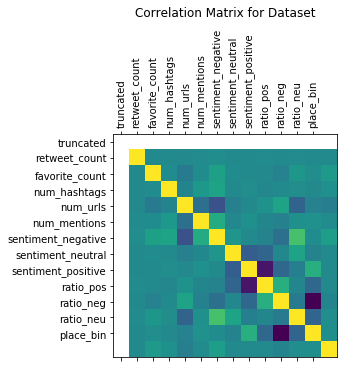

In [22]:


plt.matshow(tweets_corr.corr())
plt.title('Correlation Matrix for Dataset', y=1.5)
plt.xticks(range(len(tweets_bots.columns)), tweets_bots.columns);
plt.yticks(range(len(tweets_bots.columns)), tweets_bots.columns);
plt.xticks(rotation=90)



In [14]:
def compare_hist(ax, column):
    bins = (max(tweets_hums_re[column]) - min(tweets_hums_re[column]))/15
    plot_title='Histogram of Values for Twitter Bot Detection Dataset Feature: "' + str(column) +'"'
    xlabelval='Values for feature: ' + str(column)
    ax[i].hist(tweets_hums_re[column], label=['human'], alpha=0.5, bins=15)
    ax[i].hist(tweets_bots[column], label=['bot'], color='red', alpha=0.5, bins=15)
    ax[i].set_title(plot_title)
    ax[i].set_xlabel(xlabelval)
    ax[i].set_ylabel('Frequency')
    ax[i].legend()

In [23]:
tweets_hums_re = resample(tweets_hums, n_samples=len(tweets_bots), replace=False)

/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


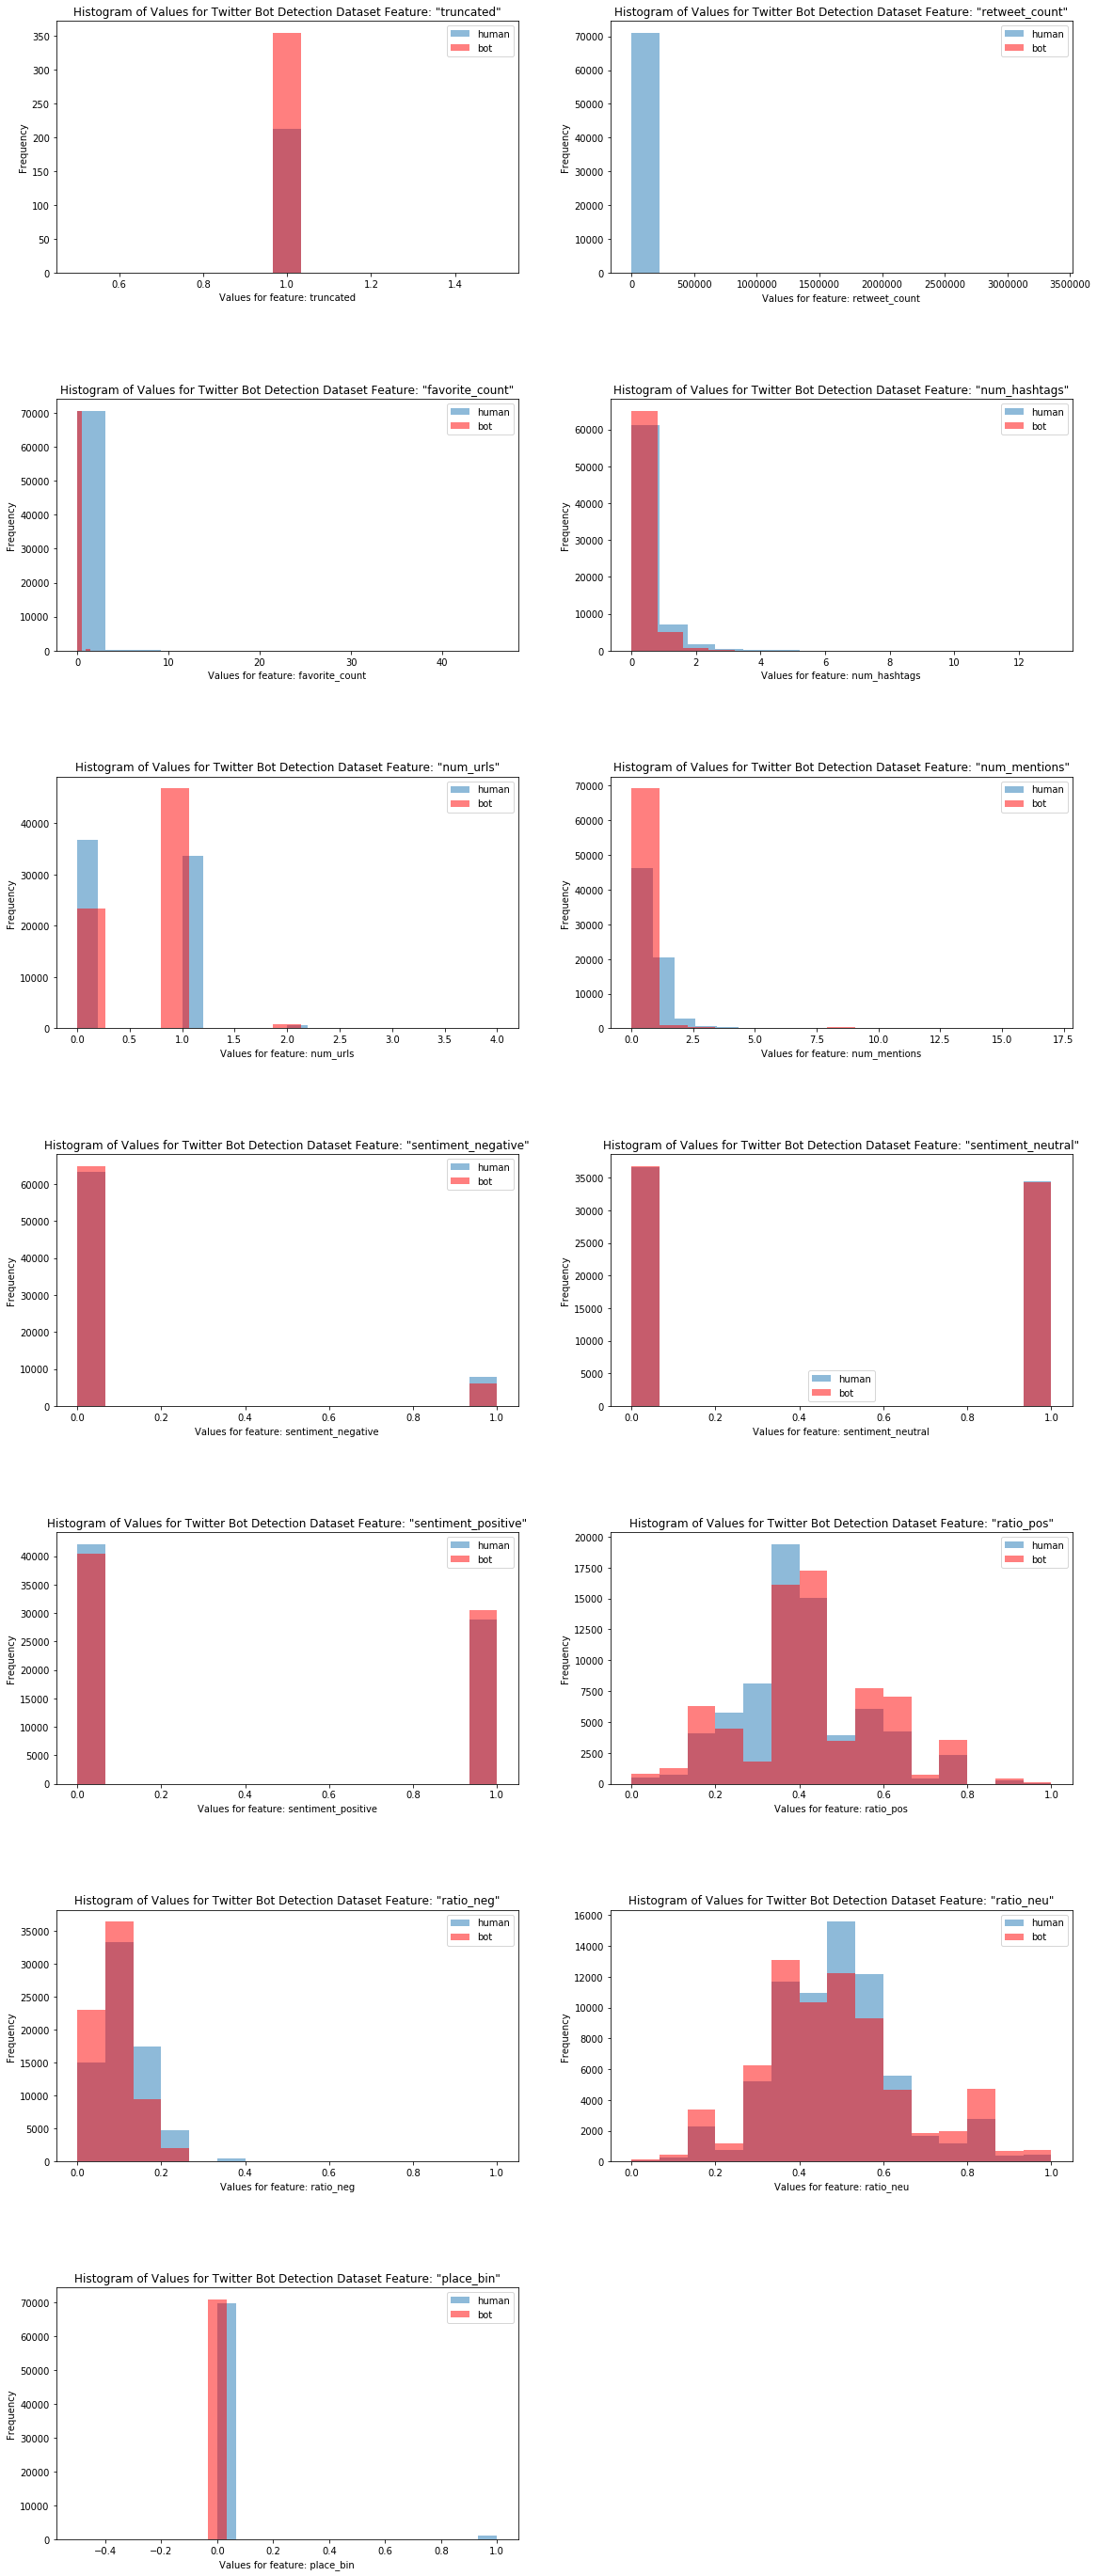

In [30]:
fig, ax = plt.subplots(7,2, figsize=(5,2.5))
plt.subplots_adjust(left=2, bottom=None, right=5, top=15, wspace=None, hspace=0.5)
ax = ax.ravel()
i=0
j=0
for column in tweets_hums.columns: 
    j=0
    bins = (max(tweets_hums_re[column]) - min(tweets_hums_re[column]))/15
    plot_title='Histogram of Values for Twitter Bot Detection Dataset Feature: "' + str(column) +'"'
    xlabelval='Values for feature: ' + str(column)
    ax[i].hist(tweets_hums_re[column], label=['human'], alpha=0.5, bins=15)
    ax[i].hist(tweets_bots[column], label=['bot'], color='red', alpha=0.5, bins=15)
    ax[i].set_title(plot_title)
    ax[i].set_xlabel(xlabelval)
    ax[i].set_ylabel('Frequency')
    ax[i].legend()
    i+=1
fig.delaxes(ax[13])   

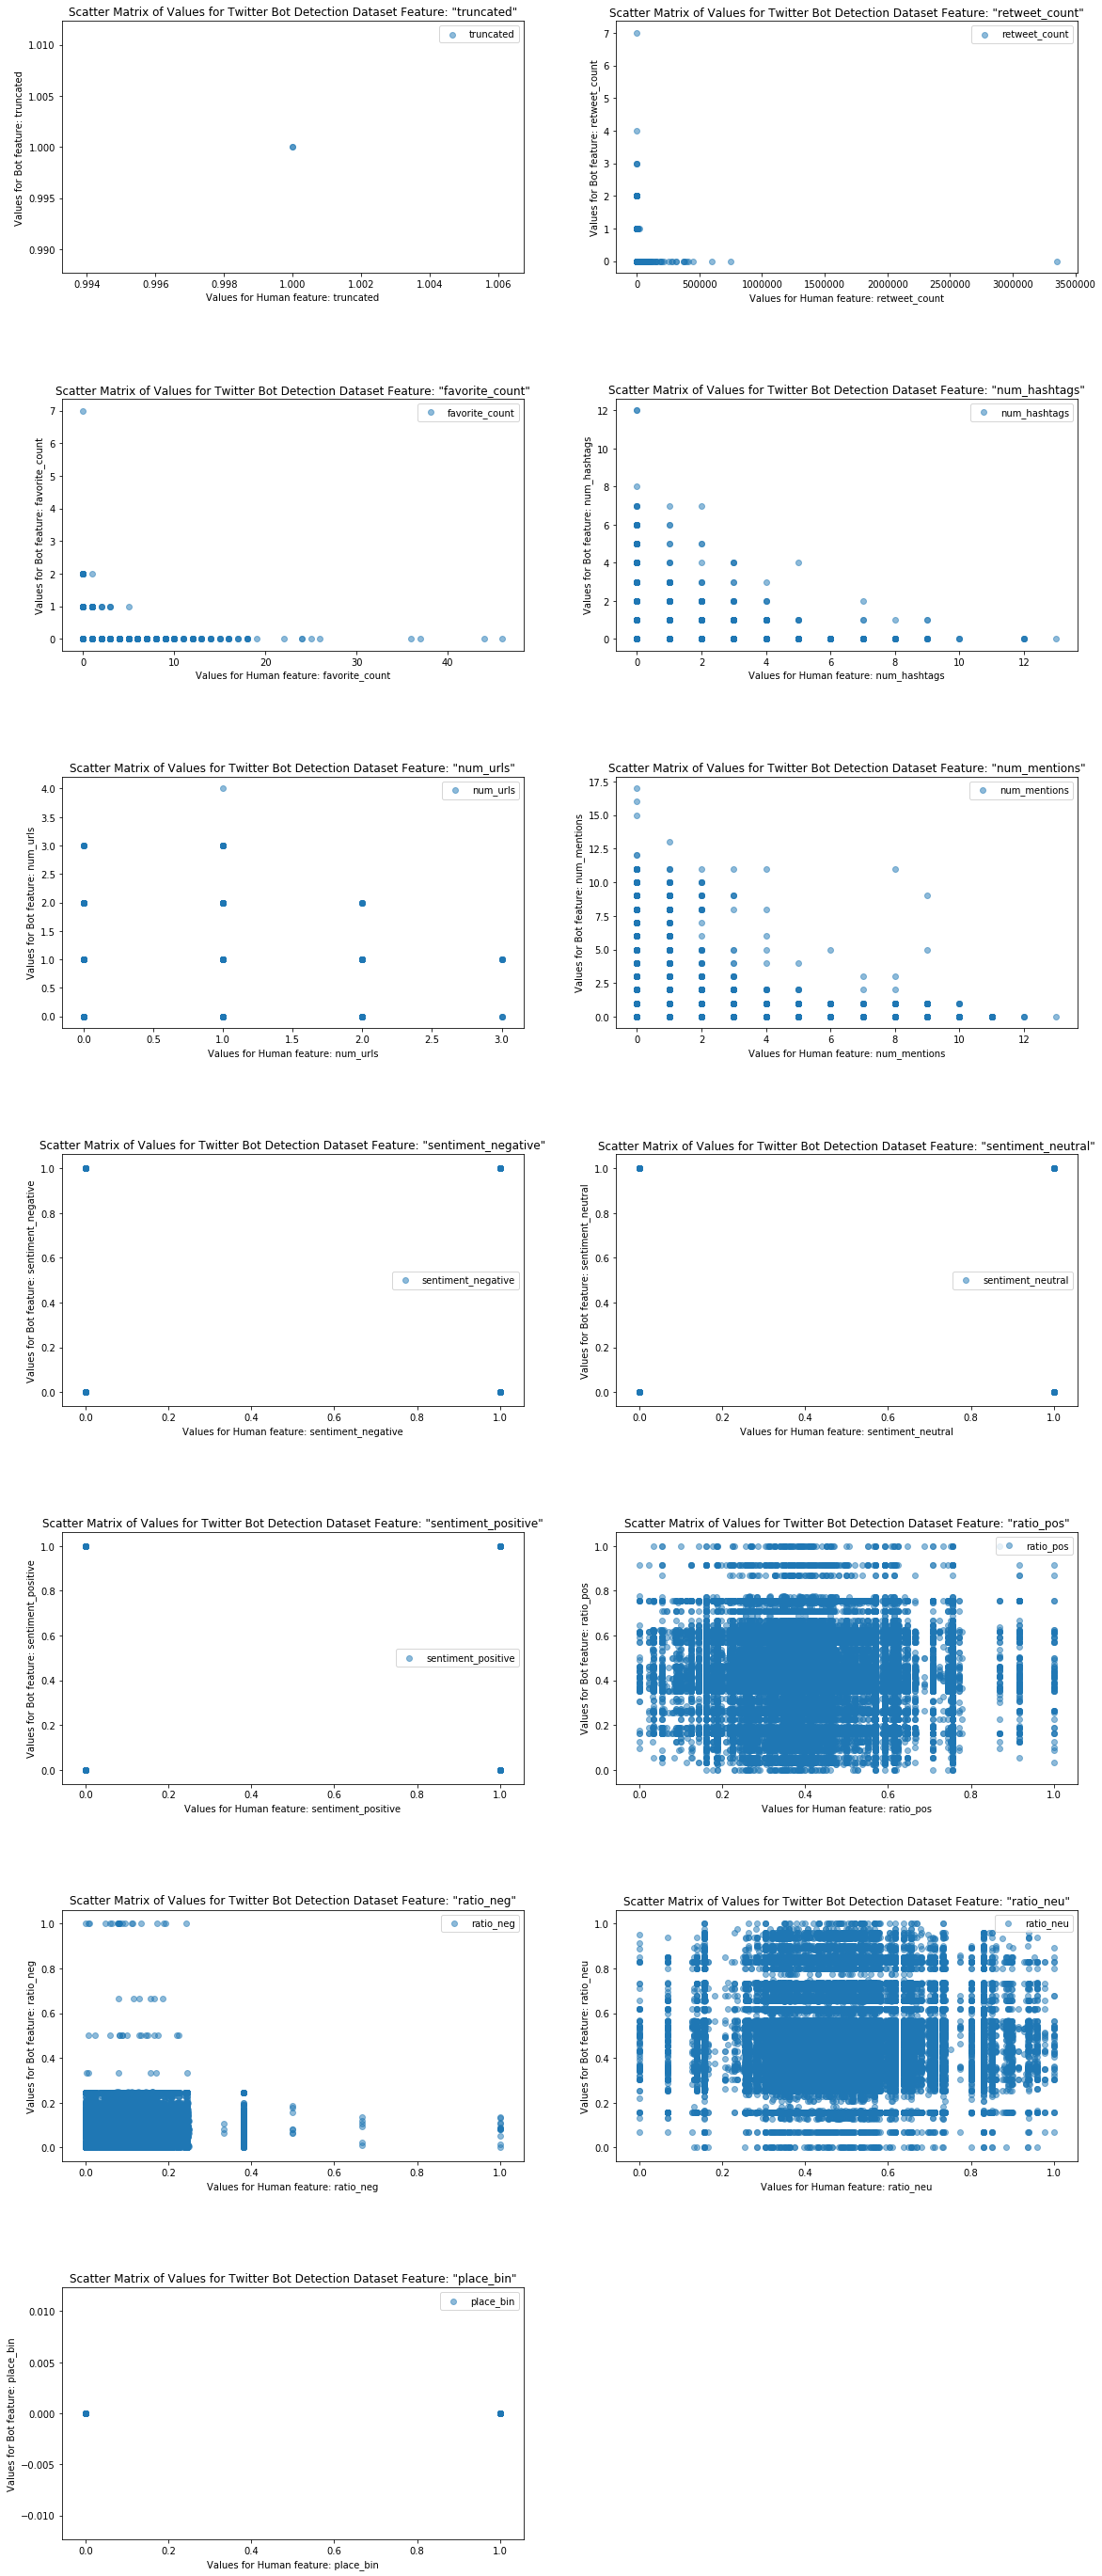

In [29]:
fig, ax = plt.subplots(7,2, figsize=(5,2.5))
plt.subplots_adjust(left=2, bottom=None, right=5, top=15, wspace=None, hspace=0.5)
ax = ax.ravel()
i=0
j=0
for column in tweets_hums.columns: 
    j=0
    plot_title='Scatter Matrix of Values for Twitter Bot Detection Dataset Feature: "' + str(column) +'"'
    xlabelval='Values for Human feature: ' + str(column)
    ylabelval='Values for Bot feature: ' + str(column)
    ax[i].scatter(tweets_hums_re[column], tweets_bots[column],  alpha=0.5)
    ax[i].set_title(plot_title)
    ax[i].set_xlabel(xlabelval)
    ax[i].set_ylabel(ylabelval)
    ax[i].legend()
    i+=1
fig.delaxes(ax[13])   

### Resources


https://www.geeksforgeeks.org/twitter-sentiment-analysis-using-python/

https://codereview.stackexchange.com/questions/181152/identify-and-extract-urls-from-text-corpus

https://en.wikipedia.org/wiki/Naive_Bayes_classifier

https://streamhacker.com/2010/05/10/text-classification-sentiment-analysis-naive-bayes-classifier/

https://nlpforhackers.io/topic-modeling/

https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24

https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21

https://towardsdatascience.com/sentiment-analysis-with-python-part-1-5ce197074184

http://www.nltk.org/book/ch06.html

https://medium.freecodecamp.org/basic-data-analysis-on-twitter-with-python-251c2a85062e 
